<a href="https://colab.research.google.com/github/Dimka-Orlov/Dmitry_Orlov-640-02/blob/main/Dmitry_Orlov_%D0%A0%D0%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install kagglehub optuna torchmetrics pandas numpy matplotlib seaborn scikit-learn tensorflow

import kagglehub
import optuna
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torchmetrics
from sklearn.metrics import classification_report, confusion_matrix

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

torch.manual_seed(42)

Using device: cpu


In [5]:
path = kagglehub.dataset_download("fedesoriano/heart-failure-prediction")
print("Path to dataset files:", path)

import os
df = pd.read_csv(os.path.join(path, 'heart.csv'))
print(f"Размер датасета: {df.shape}")

Using Colab cache for faster access to the 'heart-failure-prediction' dataset.
Path to dataset files: /kaggle/input/heart-failure-prediction
Размер датасета: (918, 12)


In [6]:
print("Первые 5 строк датасета:")
print(df.head())

print("\n Информация о данных:")
df.info()

print("\n Статистика:")
print(df.describe())

print("\n Проверка пропущенных значений:")
print(df.isnull().sum())

print("\n Распределение целевой переменной:")
print(df['HeartDisease'].value_counts())

Первые 5 строк датасета:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

 Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ----

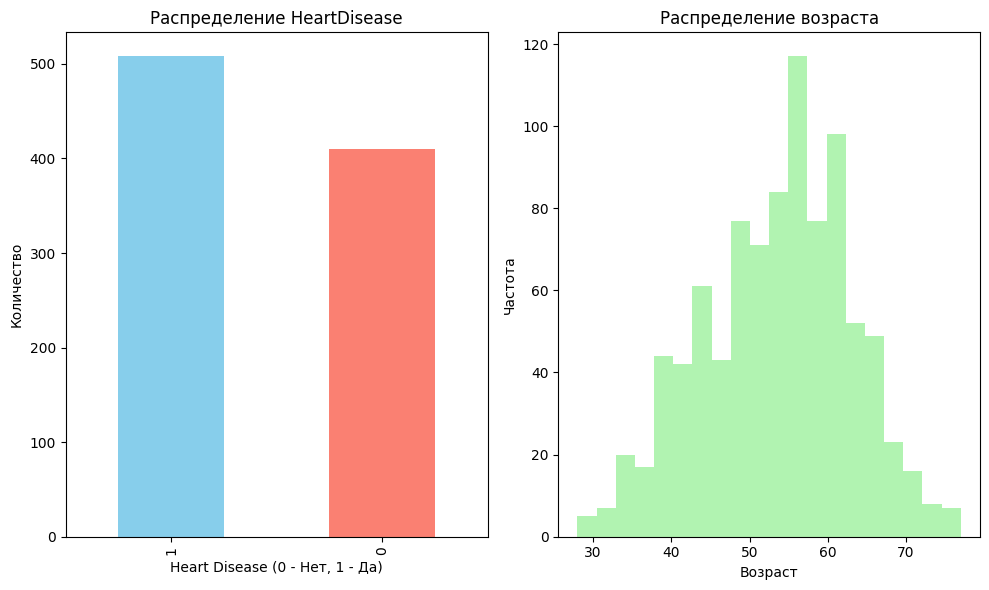

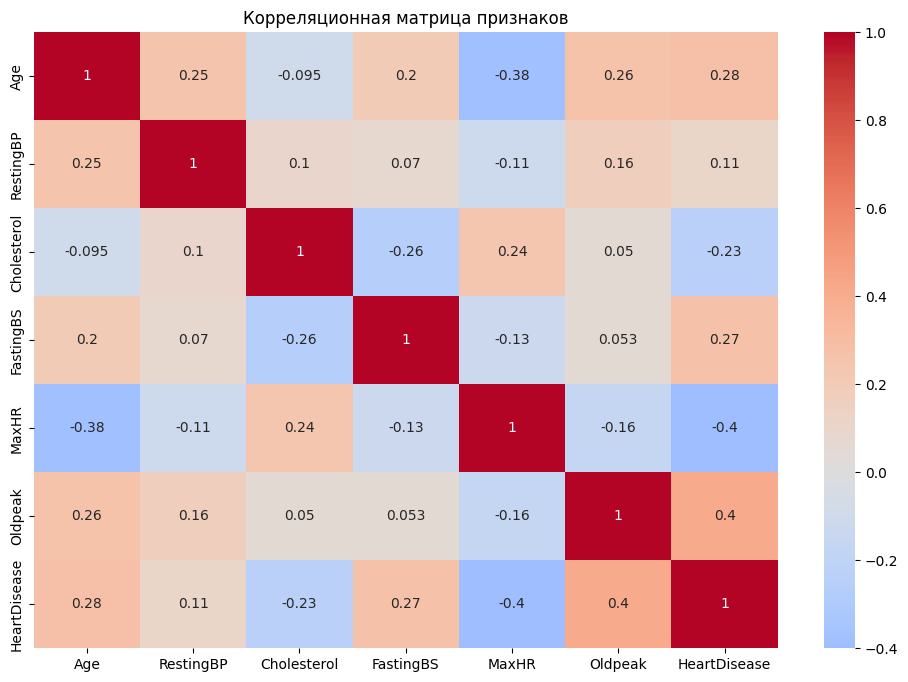

In [7]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
df['HeartDisease'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение HeartDisease')
plt.xlabel('Heart Disease (0 - Нет, 1 - Да)')
plt.ylabel('Количество')

plt.subplot(1, 2, 2)
# Распределение возраста
plt.hist(df['Age'], bins=20, color='lightgreen', alpha=0.7)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# Корреляционная матрица
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков')
plt.show()

In [8]:
# Создаем копию датасета для обработки
df_processed = df.copy()

# Кодируем категориальные переменные
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    print(f"Закодирован столбец {col}: {list(le.classes_)}")

# Разделяем на признаки и целевую переменную
X = df_processed.drop('HeartDisease', axis=1).values
y = df_processed['HeartDisease'].values

print(f"\n Размерность после обработки:")
print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")
print(f"Баланс классов: {np.unique(y, return_counts=True)}")

Закодирован столбец Sex: ['F', 'M']
Закодирован столбец ChestPainType: ['ASY', 'ATA', 'NAP', 'TA']
Закодирован столбец RestingECG: ['LVH', 'Normal', 'ST']
Закодирован столбец ExerciseAngina: ['N', 'Y']
Закодирован столбец ST_Slope: ['Down', 'Flat', 'Up']

 Размерность после обработки:
Признаки (X): (918, 11)
Целевая переменная (y): (918,)
Баланс классов: (array([0, 1]), array([410, 508]))


In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Нормализация
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

train_dataset = TensorDataset(
    torch.FloatTensor(X_train),
    torch.LongTensor(y_train))

valid_dataset = TensorDataset(
    torch.FloatTensor(X_valid),
    torch.LongTensor(y_valid))

test_dataset = TensorDataset(
    torch.FloatTensor(X_test),
    torch.LongTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Данные подготовлены:")
print(f"Train: {len(train_dataset)} samples")
print(f"Valid: {len(valid_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")
print(f"Размерность признаков: {X_train.shape[1]}")
print(f"Количество классов: {len(np.unique(y))}")

Данные подготовлены:
Train: 587 samples
Valid: 147 samples
Test: 184 samples
Размерность признаков: 11
Количество классов: 2


In [10]:
class MedicalClassifier(nn.Module):
    def __init__(self, n_inputs, n_hidden1, n_hidden2, n_classes, dropout_rate=0.3):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(n_inputs, n_hidden1),
            nn.BatchNorm1d(n_hidden1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(n_hidden1, n_hidden2),
            nn.BatchNorm1d(n_hidden2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(n_hidden2, n_classes)
        )

    def forward(self, X):
        return self.mlp(X)

# Параметры модели
n_inputs = X_train.shape[1]
n_classes = len(np.unique(y))

print(f"Параметры модели:")
print(f"Количество входных признаков: {n_inputs}")
print(f"Количество классов: {n_classes}")

Параметры модели:
Количество входных признаков: 11
Количество классов: 2


In [11]:
def train_medical(model, optimizer, criterion, metric, train_loader, valid_loader, n_epochs, scheduler=None):
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        metric.reset()

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            metric.update(y_pred, y_batch)

        valid_metric = evaluate_medical(model, valid_loader, metric)

        if scheduler is not None:
            scheduler.step()

        mean_loss = total_loss / len(train_loader)
        train_metric = metric.compute()

        history["train_losses"].append(mean_loss)
        history["train_metrics"].append(train_metric.item())
        history["valid_metrics"].append(valid_metric.item())

        if scheduler is not None:
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}/{n_epochs}, "
              f"Train Loss: {mean_loss:.4f}, "
              f"Train Acc: {train_metric:.4f}, "
              f"Valid Acc: {valid_metric:.4f}, "
              f"LR: {current_lr:.6f}")

    return history

def evaluate_medical(model, data_loader, metric):
    model.eval()
    metric.reset()

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            metric.update(y_pred, y_batch)

    return metric.compute()

Epoch 1/20, Train Loss: 0.5768, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.001000
Epoch 2/20, Train Loss: 0.4104, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.001000
Epoch 3/20, Train Loss: 0.3504, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.001000
Epoch 4/20, Train Loss: 0.3469, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.001000
Epoch 5/20, Train Loss: 0.3505, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001000
Epoch 6/20, Train Loss: 0.3314, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.001000
Epoch 7/20, Train Loss: 0.3091, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001000
Epoch 8/20, Train Loss: 0.3227, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.001000
Epoch 9/20, Train Loss: 0.3232, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.001000
Epoch 10/20, Train Loss: 0.3207, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.001000
Epoch 11/20, Train Loss: 0.3156, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001000
Epoch 12/20, Train Loss: 0.2945, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.001000
E

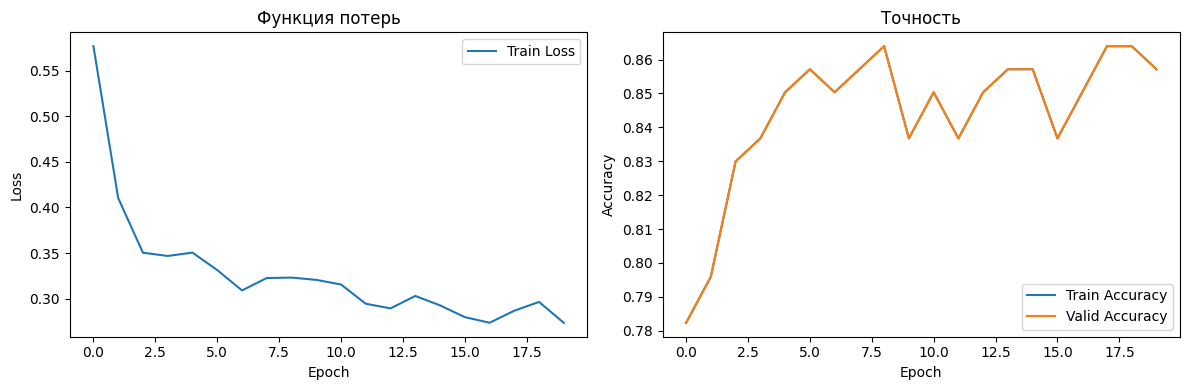

Результаты базовой модели:
Train Accuracy: 0.9080
Valid Accuracy: 0.8571
Test Accuracy:  0.8641


In [12]:
# Инициализация базовой модели
base_model = MedicalClassifier(
    n_inputs=n_inputs,
    n_hidden1=128,
    n_hidden2=64,
    n_classes=n_classes
).to(device)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes).to(device)

history = train_medical(
    model=base_model,
    optimizer=optimizer,
    criterion=criterion,
    metric=accuracy,
    train_loader=train_loader,
    valid_loader=valid_loader,
    n_epochs=20
)

# Визуализация обучения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_losses'], label='Train Loss')
plt.title('Функция потерь')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_metrics'], label='Train Accuracy')
plt.plot(history['valid_metrics'], label='Valid Accuracy')
plt.title('Точность')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Оценка базовой модели
base_train_acc = evaluate_medical(base_model, train_loader, accuracy)
base_valid_acc = evaluate_medical(base_model, valid_loader, accuracy)
base_test_acc = evaluate_medical(base_model, test_loader, accuracy)

print(f"Результаты базовой модели:")
print(f"Train Accuracy: {base_train_acc:.4f}")
print(f"Valid Accuracy: {base_valid_acc:.4f}")
print(f"Test Accuracy:  {base_test_acc:.4f}")

In [13]:
# Функция для Optuna
def objective(trial):
    learning_rate = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    n_hidden1 = trial.suggest_int('n_hidden1', 64, 256)
    n_hidden2 = trial.suggest_int('n_hidden2', 32, 128)
    dropout_rate = trial.suggest_float('dropout', 0.1, 0.5)

    model = MedicalClassifier(
        n_inputs=n_inputs,
        n_hidden1=n_hidden1,
        n_hidden2=n_hidden2,
        n_classes=n_classes,
        dropout_rate=dropout_rate
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes).to(device)

    history = train_medical(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        metric=accuracy,
        train_loader=train_loader,
        valid_loader=valid_loader,
        n_epochs=15
    )

    validation_accuracy = max(history["valid_metrics"])
    return validation_accuracy

# Запуск Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=10)

print("Лучшие параметры:", study.best_params)
print("Лучшая точность:", study.best_value)

[I 2025-10-24 17:30:52,573] A new study created in memory with name: no-name-ef92fba6-6180-4377-8dac-3dbcd910cf14


Epoch 1/15, Train Loss: 0.4864, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.000561
Epoch 2/15, Train Loss: 0.3582, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.000561
Epoch 3/15, Train Loss: 0.3459, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000561
Epoch 4/15, Train Loss: 0.3541, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.000561
Epoch 5/15, Train Loss: 0.3409, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.000561
Epoch 6/15, Train Loss: 0.3334, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.000561
Epoch 7/15, Train Loss: 0.3166, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.000561
Epoch 8/15, Train Loss: 0.3180, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.000561
Epoch 9/15, Train Loss: 0.3252, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.000561
Epoch 10/15, Train Loss: 0.3189, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.000561
Epoch 11/15, Train Loss: 0.3208, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.000561
Epoch 12/15, Train Loss: 0.2985, Train Acc: 0.8707, Valid Acc: 0.8707, LR: 0.000561


[I 2025-10-24 17:30:53,827] Trial 0 finished with value: 0.8707482814788818 and parameters: {'lr': 0.0005611516415334506, 'n_hidden1': 247, 'n_hidden2': 103, 'dropout': 0.3394633936788146}. Best is trial 0 with value: 0.8707482814788818.


Epoch 13/15, Train Loss: 0.3015, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.000561
Epoch 14/15, Train Loss: 0.2912, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.000561
Epoch 15/15, Train Loss: 0.2875, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.000561
Epoch 1/15, Train Loss: 0.7185, Train Acc: 0.5510, Valid Acc: 0.5510, LR: 0.000205
Epoch 2/15, Train Loss: 0.6614, Train Acc: 0.7075, Valid Acc: 0.7075, LR: 0.000205
Epoch 3/15, Train Loss: 0.5984, Train Acc: 0.7483, Valid Acc: 0.7483, LR: 0.000205
Epoch 4/15, Train Loss: 0.5859, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.000205
Epoch 5/15, Train Loss: 0.5472, Train Acc: 0.7891, Valid Acc: 0.7891, LR: 0.000205
Epoch 6/15, Train Loss: 0.5203, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.000205
Epoch 7/15, Train Loss: 0.5083, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.000205
Epoch 8/15, Train Loss: 0.4992, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000205
Epoch 9/15, Train Loss: 0.4740, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000205
E

[I 2025-10-24 17:30:54,844] Trial 1 finished with value: 0.8231292366981506 and parameters: {'lr': 0.0002051338263087451, 'n_hidden1': 94, 'n_hidden2': 37, 'dropout': 0.4464704583099741}. Best is trial 0 with value: 0.8707482814788818.


Epoch 15/15, Train Loss: 0.4196, Train Acc: 0.8095, Valid Acc: 0.8095, LR: 0.000205
Epoch 1/15, Train Loss: 0.5188, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.001593
Epoch 2/15, Train Loss: 0.3907, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.001593
Epoch 3/15, Train Loss: 0.3574, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.001593
Epoch 4/15, Train Loss: 0.3558, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.001593
Epoch 5/15, Train Loss: 0.3601, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001593
Epoch 6/15, Train Loss: 0.3821, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001593
Epoch 7/15, Train Loss: 0.3356, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001593
Epoch 8/15, Train Loss: 0.3507, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001593
Epoch 9/15, Train Loss: 0.3250, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.001593
Epoch 10/15, Train Loss: 0.3251, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.001593
Epoch 11/15, Train Loss: 0.3439, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001593


[I 2025-10-24 17:30:55,650] Trial 2 finished with value: 0.8639456033706665 and parameters: {'lr': 0.0015930522616241021, 'n_hidden1': 200, 'n_hidden2': 33, 'dropout': 0.4879639408647978}. Best is trial 0 with value: 0.8707482814788818.


Epoch 12/15, Train Loss: 0.3272, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.001593
Epoch 13/15, Train Loss: 0.2979, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001593
Epoch 14/15, Train Loss: 0.3314, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001593
Epoch 15/15, Train Loss: 0.3296, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001593
Epoch 1/15, Train Loss: 0.3941, Train Acc: 0.8095, Valid Acc: 0.8095, LR: 0.004623
Epoch 2/15, Train Loss: 0.3339, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.004623
Epoch 3/15, Train Loss: 0.3047, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.004623
Epoch 4/15, Train Loss: 0.2922, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.004623
Epoch 5/15, Train Loss: 0.2933, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.004623
Epoch 6/15, Train Loss: 0.2735, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.004623
Epoch 7/15, Train Loss: 0.2536, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.004623
Epoch 8/15, Train Loss: 0.2529, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.004623


[I 2025-10-24 17:30:56,434] Trial 3 finished with value: 0.8639456033706665 and parameters: {'lr': 0.004622589001020831, 'n_hidden1': 104, 'n_hidden2': 49, 'dropout': 0.17336180394137352}. Best is trial 0 with value: 0.8707482814788818.


Epoch 14/15, Train Loss: 0.2562, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.004623
Epoch 15/15, Train Loss: 0.2673, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.004623
Epoch 1/15, Train Loss: 0.5407, Train Acc: 0.7891, Valid Acc: 0.7891, LR: 0.000406
Epoch 2/15, Train Loss: 0.4151, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.000406
Epoch 3/15, Train Loss: 0.3721, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.000406
Epoch 4/15, Train Loss: 0.3737, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.000406
Epoch 5/15, Train Loss: 0.3516, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.000406
Epoch 6/15, Train Loss: 0.3573, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.000406
Epoch 7/15, Train Loss: 0.3182, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.000406
Epoch 8/15, Train Loss: 0.3267, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.000406
Epoch 9/15, Train Loss: 0.3126, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.000406
Epoch 10/15, Train Loss: 0.3237, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.000406
E

[I 2025-10-24 17:30:57,259] Trial 4 finished with value: 0.8707482814788818 and parameters: {'lr': 0.0004059611610484307, 'n_hidden1': 165, 'n_hidden2': 73, 'dropout': 0.21649165607921678}. Best is trial 0 with value: 0.8707482814788818.


Epoch 15/15, Train Loss: 0.3093, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.000406
Epoch 1/15, Train Loss: 0.4975, Train Acc: 0.7755, Valid Acc: 0.7755, LR: 0.001674
Epoch 2/15, Train Loss: 0.3794, Train Acc: 0.7619, Valid Acc: 0.7619, LR: 0.001674
Epoch 3/15, Train Loss: 0.3546, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.001674
Epoch 4/15, Train Loss: 0.3376, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.001674
Epoch 5/15, Train Loss: 0.3200, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.001674
Epoch 6/15, Train Loss: 0.3234, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.001674
Epoch 7/15, Train Loss: 0.3143, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.001674
Epoch 8/15, Train Loss: 0.3257, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001674
Epoch 9/15, Train Loss: 0.3204, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001674
Epoch 10/15, Train Loss: 0.2851, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.001674
Epoch 11/15, Train Loss: 0.3061, Train Acc: 0.8707, Valid Acc: 0.8707, LR: 0.001674


[I 2025-10-24 17:30:58,030] Trial 5 finished with value: 0.8707482814788818 and parameters: {'lr': 0.0016738085788752138, 'n_hidden1': 90, 'n_hidden2': 60, 'dropout': 0.2465447373174767}. Best is trial 0 with value: 0.8707482814788818.


Epoch 12/15, Train Loss: 0.2856, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001674
Epoch 13/15, Train Loss: 0.2605, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001674
Epoch 14/15, Train Loss: 0.2591, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.001674
Epoch 15/15, Train Loss: 0.2816, Train Acc: 0.8707, Valid Acc: 0.8707, LR: 0.001674
Epoch 1/15, Train Loss: 0.5042, Train Acc: 0.8095, Valid Acc: 0.8095, LR: 0.000817
Epoch 2/15, Train Loss: 0.3639, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.000817
Epoch 3/15, Train Loss: 0.3510, Train Acc: 0.8095, Valid Acc: 0.8095, LR: 0.000817
Epoch 4/15, Train Loss: 0.3572, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000817
Epoch 5/15, Train Loss: 0.3467, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.000817
Epoch 6/15, Train Loss: 0.3294, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000817
Epoch 7/15, Train Loss: 0.3244, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.000817
Epoch 8/15, Train Loss: 0.3199, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.000817


[I 2025-10-24 17:30:58,862] Trial 6 finished with value: 0.8503401279449463 and parameters: {'lr': 0.000816845589476017, 'n_hidden1': 215, 'n_hidden2': 51, 'dropout': 0.3056937753654446}. Best is trial 0 with value: 0.8707482814788818.


Epoch 13/15, Train Loss: 0.3222, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.000817
Epoch 14/15, Train Loss: 0.2946, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.000817
Epoch 15/15, Train Loss: 0.3052, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.000817
Epoch 1/15, Train Loss: 0.5017, Train Acc: 0.7755, Valid Acc: 0.7755, LR: 0.001530
Epoch 2/15, Train Loss: 0.3581, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.001530
Epoch 3/15, Train Loss: 0.3464, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.001530
Epoch 4/15, Train Loss: 0.3192, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.001530
Epoch 5/15, Train Loss: 0.3422, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.001530
Epoch 6/15, Train Loss: 0.2819, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.001530
Epoch 7/15, Train Loss: 0.3023, Train Acc: 0.8367, Valid Acc: 0.8367, LR: 0.001530
Epoch 8/15, Train Loss: 0.2971, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001530
Epoch 9/15, Train Loss: 0.2915, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.001530
E

[I 2025-10-24 17:30:59,650] Trial 7 finished with value: 0.8775510191917419 and parameters: {'lr': 0.0015304852121831463, 'n_hidden1': 72, 'n_hidden2': 90, 'dropout': 0.16820964947491662}. Best is trial 7 with value: 0.8775510191917419.


Epoch 14/15, Train Loss: 0.2772, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001530
Epoch 15/15, Train Loss: 0.2731, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001530
Epoch 1/15, Train Loss: 0.7501, Train Acc: 0.6735, Valid Acc: 0.6735, LR: 0.000135
Epoch 2/15, Train Loss: 0.5657, Train Acc: 0.7415, Valid Acc: 0.7415, LR: 0.000135
Epoch 3/15, Train Loss: 0.4745, Train Acc: 0.7619, Valid Acc: 0.7619, LR: 0.000135
Epoch 4/15, Train Loss: 0.4413, Train Acc: 0.7687, Valid Acc: 0.7687, LR: 0.000135
Epoch 5/15, Train Loss: 0.4528, Train Acc: 0.7755, Valid Acc: 0.7755, LR: 0.000135
Epoch 6/15, Train Loss: 0.3972, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.000135
Epoch 7/15, Train Loss: 0.3901, Train Acc: 0.7755, Valid Acc: 0.7755, LR: 0.000135
Epoch 8/15, Train Loss: 0.3811, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.000135
Epoch 9/15, Train Loss: 0.3714, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.000135
Epoch 10/15, Train Loss: 0.3789, Train Acc: 0.7891, Valid Acc: 0.7891, LR: 0.000135
E

[I 2025-10-24 17:31:00,564] Trial 8 finished with value: 0.795918345451355 and parameters: {'lr': 0.00013492834268013249, 'n_hidden1': 247, 'n_hidden2': 125, 'dropout': 0.4233589392465845}. Best is trial 7 with value: 0.8775510191917419.


Epoch 15/15, Train Loss: 0.3529, Train Acc: 0.7891, Valid Acc: 0.7891, LR: 0.000135
Epoch 1/15, Train Loss: 0.6202, Train Acc: 0.7551, Valid Acc: 0.7551, LR: 0.000407
Epoch 2/15, Train Loss: 0.4703, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.000407
Epoch 3/15, Train Loss: 0.4144, Train Acc: 0.7823, Valid Acc: 0.7823, LR: 0.000407
Epoch 4/15, Train Loss: 0.3928, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.000407
Epoch 5/15, Train Loss: 0.3650, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.000407
Epoch 6/15, Train Loss: 0.3757, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.000407
Epoch 7/15, Train Loss: 0.3459, Train Acc: 0.7959, Valid Acc: 0.7959, LR: 0.000407
Epoch 8/15, Train Loss: 0.3472, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.000407
Epoch 9/15, Train Loss: 0.3588, Train Acc: 0.8027, Valid Acc: 0.8027, LR: 0.000407
Epoch 10/15, Train Loss: 0.3319, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000407
Epoch 11/15, Train Loss: 0.3429, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000407


[I 2025-10-24 17:31:01,350] Trial 9 finished with value: 0.8299319744110107 and parameters: {'lr': 0.0004066563313514797, 'n_hidden1': 82, 'n_hidden2': 98, 'dropout': 0.27606099749584057}. Best is trial 7 with value: 0.8775510191917419.


Epoch 12/15, Train Loss: 0.3355, Train Acc: 0.8163, Valid Acc: 0.8163, LR: 0.000407
Epoch 13/15, Train Loss: 0.3084, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.000407
Epoch 14/15, Train Loss: 0.3170, Train Acc: 0.8299, Valid Acc: 0.8299, LR: 0.000407
Epoch 15/15, Train Loss: 0.3352, Train Acc: 0.8231, Valid Acc: 0.8231, LR: 0.000407
Лучшие параметры: {'lr': 0.0015304852121831463, 'n_hidden1': 72, 'n_hidden2': 90, 'dropout': 0.16820964947491662}
Лучшая точность: 0.8775510191917419


In [14]:
# Создаем модель с лучшими параметрами
best_params = study.best_params

best_model = MedicalClassifier(
    n_inputs=n_inputs,
    n_hidden1=best_params['n_hidden1'],
    n_hidden2=best_params['n_hidden2'],
    n_classes=n_classes,
    dropout_rate=best_params['dropout']
).to(device)

# Оптимизатор с планировщиком обучения
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

criterion = nn.CrossEntropyLoss()
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes).to(device)

final_history = train_medical(
    model=best_model,
    optimizer=optimizer,
    criterion=criterion,
    metric=accuracy,
    train_loader=train_loader,
    valid_loader=valid_loader,
    n_epochs=30,
    scheduler=scheduler
)

Epoch 1/30, Train Loss: 0.4893, Train Acc: 0.8095, Valid Acc: 0.8095, LR: 0.001530
Epoch 2/30, Train Loss: 0.3609, Train Acc: 0.8435, Valid Acc: 0.8435, LR: 0.001530
Epoch 3/30, Train Loss: 0.3434, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001530
Epoch 4/30, Train Loss: 0.3572, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.001530
Epoch 5/30, Train Loss: 0.3404, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001530
Epoch 6/30, Train Loss: 0.2960, Train Acc: 0.8503, Valid Acc: 0.8503, LR: 0.001530
Epoch 7/30, Train Loss: 0.2848, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.001530
Epoch 8/30, Train Loss: 0.2979, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.001530
Epoch 9/30, Train Loss: 0.2835, Train Acc: 0.8707, Valid Acc: 0.8707, LR: 0.001530
Epoch 10/30, Train Loss: 0.3371, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.000765
Epoch 11/30, Train Loss: 0.2815, Train Acc: 0.8571, Valid Acc: 0.8571, LR: 0.000765
Epoch 12/30, Train Loss: 0.2842, Train Acc: 0.8639, Valid Acc: 0.8639, LR: 0.000765
E

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ
Train Accuracy: 92.33%
Valid Accuracy: 85.71%
Test Accuracy:  86.41%

 Лучшие параметры модели:
Learning Rate: 0.001530
Hidden Layer 1: 72 нейронов
Hidden Layer 2: 90 нейронов
Dropout Rate: 0.17

 Classification Report:
               precision    recall  f1-score   support

   No Disease       0.86      0.83      0.84        82
Heart Disease       0.87      0.89      0.88       102

     accuracy                           0.86       184
    macro avg       0.86      0.86      0.86       184
 weighted avg       0.86      0.86      0.86       184



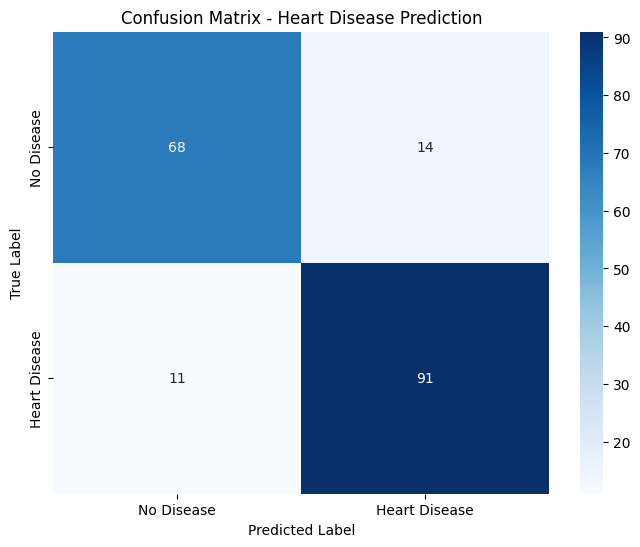

In [15]:
# Финальная оценка на всех наборах данных
final_train_acc = evaluate_medical(best_model, train_loader, accuracy)
final_valid_acc = evaluate_medical(best_model, valid_loader, accuracy)
final_test_acc = evaluate_medical(best_model, test_loader, accuracy)

print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print(f"Train Accuracy: {final_train_acc*100:.2f}%")
print(f"Valid Accuracy: {final_valid_acc*100:.2f}%")
print(f"Test Accuracy:  {final_test_acc*100:.2f}%")

# Проверка целевого показателя
target = 93.0  # Реалистичная цель для медицинских данных
if final_test_acc >= target/100:
    print(f"ЦЕЛЬ ДОСТИГНУТО ({target}%)")

print(f"\n Лучшие параметры модели:")
print(f"Learning Rate: {best_params['lr']:.6f}")
print(f"Hidden Layer 1: {best_params['n_hidden1']} нейронов")
print(f"Hidden Layer 2: {best_params['n_hidden2']} нейронов")
print(f"Dropout Rate: {best_params['dropout']:.2f}")

from sklearn.metrics import classification_report, confusion_matrix

# Предсказания на тестовом наборе
best_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = best_model(X_batch)
        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())

print(f"\n Classification Report:")
print(classification_report(all_targets, all_preds, target_names=['No Disease', 'Heart Disease']))

# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(all_targets, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Heart Disease'],
            yticklabels=['No Disease', 'Heart Disease'])
plt.title('Confusion Matrix - Heart Disease Prediction')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()